In [1]:
%load_ext autoreload
%autoreload 2
from structs import KernelParams, ModelParams
from data import get_dataset
import jax.numpy as jnp

D = 1
train_ds, test_ds = get_dataset('matern_toy', n1=200, n2=200, d=D)
print(train_ds.x.shape, train_ds.y.shape, test_ds.x.shape, test_ds.y.shape)

kernel_params_init = KernelParams(signal_scale=1.0, length_scale=jnp.array(D * [1.]))
model_params_init = ModelParams(noise_scale=1., kernel_params=kernel_params_init)

(360, 1) (360,) (40, 1) (40,)


In [2]:
from mll_optimiser import fit
from config import TrainConfig
from kernels import matern32_kernel_fn, matern32_kernel_grad_fn, matern32_feature_params_fn
from gradient_estimators import exact_gradient, standard_gradient, pathwise_gradient
from linear_solvers import chol_solver, cg_solver, ap_solver, sgd_solver


cfg = TrainConfig(
    seed=12345,
    dataset_name=None,
    dataset_split=None,
    n_subsample=None,
    subsample_seed=None,
    kernel_name=None,
    n_features=200,
    pretrained_init=False,
    noise_scale_init=1.0,
    signal_scale_init=1.0,
    length_scale_init=1.0,
    noise_scale_min=0.0,
    n_iterations=100,
    learning_rate=0.1,
    estimator_name="pathwise",
    warm_start=True,
    n_samples=16,
    pathwise_init=False,
    solver_name="sgd",
    rtol_y=0.01,
    rtol_z=0.01,
    max_epochs=1000,
    batch_size=100,
    log_wandb=False,
    log_verbose=True,
    log_metrics_exact=True,
    log_metrics_samples=True,
    checkpoint_interval=0,)

checkpoint = fit(train_ds=train_ds,
                 test_ds=test_ds,
                 kernel_fn=matern32_kernel_fn,
                 kernel_grad_fn=matern32_kernel_grad_fn,
                 feature_params_fn=matern32_feature_params_fn,
                 gradient_estimator=pathwise_gradient,
                 solver=sgd_solver,
                 cfg=cfg)

print("Optimised model_params:")
print(checkpoint['model_params'])
print(f"Train time: {checkpoint['train_time']:.2f}s")

Using float32
Initial model_params:
ModelParams(noise_scale=Array(1., dtype=float32), kernel_params=KernelParams(signal_scale=Array(1., dtype=float32), length_scale=Array([1.], dtype=float32)))
i: 0, mll: -405.4332, train_rmse: 0.5149, train_llh: -1.0577, test_rmse: 0.5248, test_llh: -1.0624, train_time: 0.00, solver_time: 0.00, solver_iters: 0, r_norm_y: 0.0000, r_norm_z: 0.0000, eval_time: 0.1917, train_rmse_samples: 0.5150, train_llh_samples: -1.0614, test_rmse_samples: 0.5250, test_llh_samples: -1.0667
i: 1, mll: -384.6154, train_rmse: 0.4824, train_llh: -0.9939, test_rmse: 0.4884, test_llh: -0.9969, train_time: 0.71, solver_time: 0.38, solver_iters: 137, r_norm_y: 0.0079, r_norm_z: 0.0096, eval_time: 0.1944, train_rmse_samples: 0.4825, train_llh_samples: -0.9988, test_rmse_samples: 0.4889, test_llh_samples: -1.0033
i: 2, mll: -363.1815, train_rmse: 0.4522, train_llh: -0.9292, test_rmse: 0.4526, test_llh: -0.9290, train_time: 0.80, solver_time: 0.46, solver_iters: 94, r_norm_y: 0.0

In [3]:
import jax.scipy as jsp
x_pred = jnp.linspace(-3., 3., 100).reshape(-1, 1)

def predict_exact(model_params):
    K_train = matern32_kernel_fn(train_ds.x, train_ds.x, model_params.kernel_params)
    K_pred = matern32_kernel_fn(x_pred, x_pred, model_params.kernel_params)
    K_pred_train = matern32_kernel_fn(x_pred, train_ds.x, model_params.kernel_params)
    
    H = K_train + (model_params.noise_scale ** 2) * jnp.eye(train_ds.N)

    H_cho_factor, lower = jsp.linalg.cho_factor(H)
    H_inv_y = jsp.linalg.cho_solve((H_cho_factor, lower), train_ds.y)
    H_inv_K_train_test = jsp.linalg.cho_solve((H_cho_factor, lower), K_pred_train.T)

    y_pred_mean = K_pred_train @ H_inv_y
    y_pred_var = K_pred - K_pred_train @ H_inv_K_train_test
    y_pred_std = jnp.sqrt(jnp.diag(y_pred_var) + (model_params.noise_scale ** 2))
    return y_pred_mean, y_pred_std

y_pred_mean, y_pred_std = predict_exact(checkpoint['model_params'])

def predict_pathwise(model_params, train_state):
    from kernels import feature_fn
    features = feature_fn(x_pred, model_params.kernel_params, train_state.feature_params)
    f0 = features @ train_state.w

    K_pred_train = matern32_kernel_fn(x_pred, train_ds.x, model_params.kernel_params)
    
    temp = K_pred_train @ train_state.v0
    mean = temp[:, 0:1]
    correction = temp[:, 1:]

    samples = f0 + mean - correction
    return samples

y_pred_samples = predict_pathwise(checkpoint['model_params'], checkpoint['train_state'])

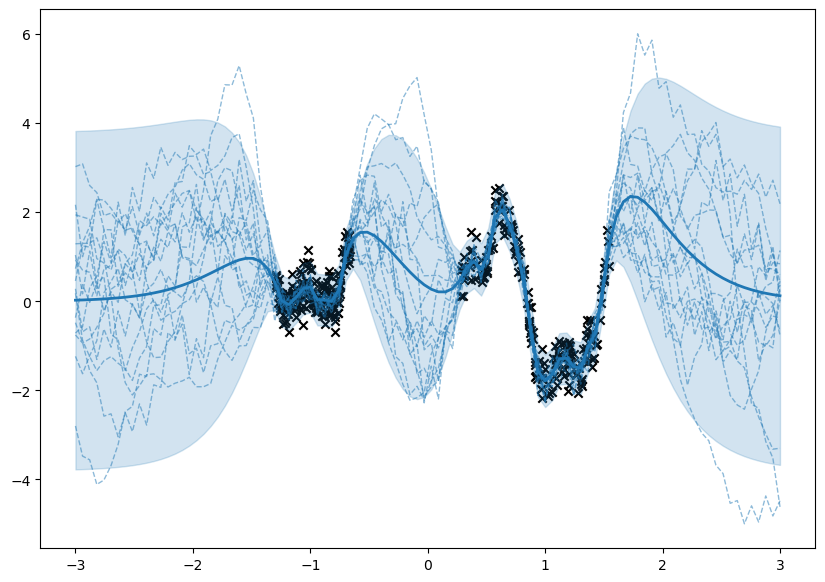

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 7), dpi=100)
ax = fig.add_subplot(111)

ax.scatter(train_ds.x, train_ds.y, marker='x', color='k')
ax.plot(x_pred, y_pred_samples, color='tab:blue', ls='--', linewidth=1, alpha=0.5)
ax.plot(x_pred, y_pred_mean, color='tab:blue', ls='-', linewidth=2)
ax.fill_between(x_pred.squeeze(), y_pred_mean - 2 * y_pred_std, y_pred_mean + 2 * y_pred_std, color='tab:blue', alpha=0.2)